In [138]:
import os
from nipype.interfaces import io as nio  # Data i/o
from nipype.interfaces import spm as spm  # spm
# from nipype.interfaces import matlab as mlab    # how to run matlab
from nipype.interfaces import fsl as fsl  # fsl
from nipype.interfaces import utility as niu  # utility
from nipype.pipeline import engine as pe  # pypeline engine
from nipype.algorithms import rapidart as ra  # artifact detection
from nipype.algorithms import modelgen as model  # model specification
from nipype.algorithms import misc
from nipype.interfaces.utility import Rename

In [139]:
base_dir = os.getcwd()

aal = 'fsl/aal/AAL3v1.nii'
target = 'fsl/std/MNI152_T1_2mm_brain.nii'


In [140]:
data_dir = os.path.join(base_dir, 'processed/smoothed/')
subject_list = ["08"]
runs = ["1", "2"]
fwhm_list = ["4"]
infosource = pe.Node(interface=niu.IdentityInterface(fields=['subject_id', 'run', 'fwhm']), name='infosource')
infosource.iterables = [('subject_id', subject_list), ('run', runs), ('fwhm', fwhm_list)]

In [141]:
datasource = pe.Node(
    interface=nio.DataGrabber(
        infields=['subject_id', 'run', 'fwhm'], outfields=['func']),
    name='datasource')
datasource.inputs.base_directory = data_dir
datasource.inputs.template = '*'
datasource.inputs.sort_filelist = True

datasource.inputs.template_args = {
    'func': [['run', 'subject_id', 'fwhm', 'subject_id', 'run']]
}

datasource.inputs.field_template = {'func': '_run_%s_subject_id_%s/_fwhm_%s/swarsub-%s_task-flanker_run-%s_bold.nii'}

In [142]:
# test
# datasource.inputs.subject_id = '08'
# datasource.inputs.run = '1'
# datasource.inputs.fwhm = '4'

# datasource.run()

In [143]:
flirt_aff = pe.Node(interface=fsl.FLIRT(), name='flirt_aff')
flirt_aff.inputs.reference = os.path.join(base_dir, 'fsl/std/MNI152_T1_2mm_brain.nii')

In [144]:
convert_xfm = pe.Node(interface=fsl.ConvertXFM(), name='inverse_aff')

In [145]:
# input: in_file, config_file 
# output: fieldcoeff_file
fnirt = pe.Node(interface=fsl.FNIRT(), name='fnirt')
fnirt.inputs.ref_file = os.path.join(base_dir, 'fsl/std/MNI152_T1_2mm_brain.nii')
fnirt.inputs.fieldcoeff_file = True
fnirt.inputs.warped_file = 'warped'

In [146]:
# test
# fnirt = fsl.FNIRT()
# fnirt.inputs.in_file = os.path.join(base_dir, 'fsl/func/warsub-08_task-flanker_run-1_bold.nii')
# fnirt.inputs.ref_file = os.path.join(base_dir, 'fsl/std/MNI152_T1_2mm_brain.nii')
# fnirt.inputs.fieldcoeff_file = True

# res = fnirt.run()

In [147]:
# take name of a file in target space and warp coefficient
# A -> B: AwarpB
# inverse should take AwarpB and A since target space is A
# input: reference, warp
# output: inverse_wrap
inv_warp = pe.Node(interface=fsl.InvWarp(), name='inv_warp')

In [148]:

os.path.join(base_dir, 'fsl/func/warsub-08_task-flanker_run-1_bold_warpcoef.nii.gz')

'/home/chan/Documents/graduate-essay/fsl/func/warsub-08_task-flanker_run-1_bold_warpcoef.nii.gz'

In [149]:
# test
# inv_warp = fsl.InvWarp()
# inv_warp.inputs.reference = os.path.join(base_dir, 'fsl/func/warsub-08_task-flanker_run-1_bold.nii')
# inv_warp.inputs.warp = '/home/chan/Documents/graduate-essay/fsl/warped.coef.nii.gz'

# inv_warp.run()

In [160]:
flirt_aal = pe.Node(interface=fsl.FLIRT(), name='flirt_aal')
flirt_aal.inputs.in_file = os.path.join(base_dir, 'fsl/aal/AAL3v1.nii')
flirt_aal.inputs.out_file = 'aalFlirted'

In [150]:
# input: in_file, ref_file, field_file
# output: out_file
apply_warp = pe.Node(interface=fsl.ApplyWarp(), name='apply_warp')
# apply_warp.inputs.in_file = os.path.join(base_dir, 'fsl/aal/AAL_warped2MNI.nii');

In [151]:
# test
# apply_warp = fsl.ApplyWarp()
# apply_warp.inputs.in_file = os.path.join(base_dir, 'fsl/std/MNI152_T1_2mm_brain.nii')
# apply_warp.inputs.ref_file = os.path.join(base_dir, 'fsl/func/warsub-08_task-flanker_run-1_bold.nii')
# apply_warp.inputs.field_file = os.path.join(base_dir, 'warsub-08_task-flanker_run-1_bold_warpcoef_inverse.nii')

# res = apply_warp.run()

In [152]:
# used to restore flirt_aff
flirt_restore = pe.Node(interface=fsl.FLIRT(), name='flirt_restore')

In [153]:
# linear register non-linear registered atlas to MNI
flirt = pe.Node(interface=fsl.FLIRT(), name='flirt')
flirt.inputs.reference = os.path.join(base_dir, 'fsl/std/MNI152_T1_2mm_brain.nii')

In [154]:
datasink = pe.Node(nio.DataSink(), name='sinker')
datasink.inputs.base_directory = os.path.join(os.getcwd(), 'inverted')

In [161]:
workflow = pe.Workflow(name='inv_nl_register', base_dir='multi_atlas')
workflow.connect([
    (infosource, datasource, [('subject_id', 'subject_id'), ('run', 'run'), ('fwhm', 'fwhm')]),
    # (datasource, gzFunc, [('func', 'in_file')]),

    (datasource, flirt_aff, [('func', 'in_file')]),

    (flirt_aff, convert_xfm, [('out_matrix_file', 'in_file')]),

    (flirt_aff, fnirt, [('out_matrix_file', 'affine_file')]),
    (datasource, fnirt, [('func', 'in_file')]),

    (fnirt, flirt_aal, [('warped_file', 'reference')]),

    (fnirt, inv_warp, [('fieldcoeff_file', 'warp')]),
    (datasource, inv_warp, [('func', 'reference')]),

    (datasource, apply_warp, [('func', 'ref_file')]),
    (inv_warp, apply_warp, [('inverse_warp', 'field_file')]),
    (flirt_aal, apply_warp, [('out_file', 'in_file')]),

    (apply_warp, flirt_restore, [('out_file', 'in_file')]),
    (convert_xfm, flirt_restore, [('out_file', 'in_matrix_file')]),
    (datasource, flirt_restore, [('func', 'reference')]),

    (flirt_restore, flirt, [('out_file', 'in_file')]),

    (flirt, datasink, [('out_file', 'atlas')]),
    (flirt, datasink, [('out_matrix_file', 'atlas_mat')]),
])
workflow.write_graph(graph2use='flat')

230103-17:08:24,664 nipype.workflow INFO:
	 Generated workflow graph: /home/chan/Documents/graduate-essay/multi_atlas/inv_nl_register/graph.png (graph2use=flat, simple_form=True).


'/home/chan/Documents/graduate-essay/multi_atlas/inv_nl_register/graph.png'

In [162]:
workflow.run()

230103-17:09:41,132 nipype.workflow INFO:
	 Workflow inv_nl_register settings: ['check', 'execution', 'logging', 'monitoring']
230103-17:09:41,146 nipype.workflow INFO:
	 Running serially.
230103-17:09:41,146 nipype.workflow INFO:
	 [Node] Setting-up "inv_nl_register.datasource" in "/home/chan/Documents/graduate-essay/multi_atlas/inv_nl_register/_fwhm_4_run_1_subject_id_08/datasource".
230103-17:09:41,149 nipype.workflow INFO:
	 [Node] Executing "datasource" <nipype.interfaces.io.DataGrabber>
230103-17:09:41,150 nipype.workflow INFO:
	 [Node] Finished "datasource", elapsed time 0.000214s.
230103-17:09:41,152 nipype.workflow INFO:
	 [Node] Setting-up "inv_nl_register.datasource" in "/home/chan/Documents/graduate-essay/multi_atlas/inv_nl_register/_fwhm_4_run_2_subject_id_08/datasource".
230103-17:09:41,154 nipype.workflow INFO:
	 [Node] Executing "datasource" <nipype.interfaces.io.DataGrabber>
230103-17:09:41,155 nipype.workflow INFO:
	 [Node] Finished "datasource", elapsed time 0.000187

In [168]:
from nilearn import plotting

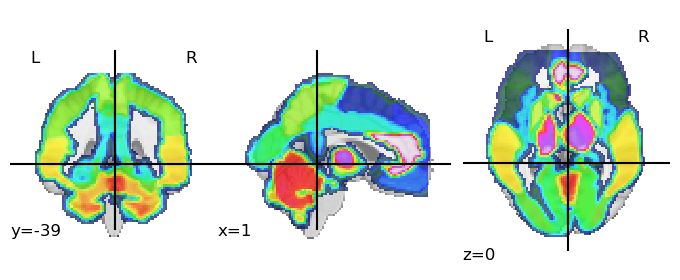

In [165]:
plotting.plot_roi('./inverted/atlas/_fwhm_4_run_2_subject_id_08/AAL3v1_flirt_warp_flirt_flirt.nii.gz')

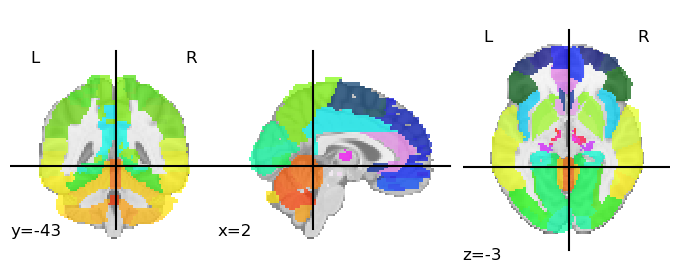

In [169]:
plotting.plot_roi('fsl/aal/AAL3v1.nii')

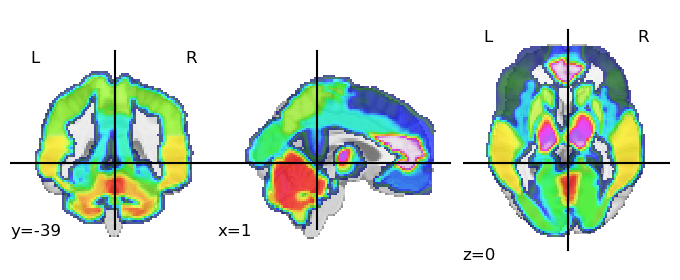

In [166]:
plotting.plot_roi('./inverted/atlas/_fwhm_4_run_2_subject_id_08/AAL_warped2MNI_warp_flirt_flirt.nii.gz')

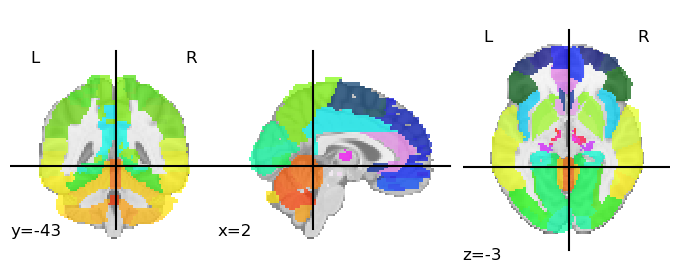